# EEG Sinyalleri ile Duygu Analizi

Bu çalışmada, EEG sinyalleri kullanılarak duygu durumu sınıflandırması yapılmaktadır.
Veri seti, Muse EEG cihazı kullanılarak toplanan beyin dalgası verilerinden oluşmaktadır.

In [1]:
# Gerekli kütüphaneler import ediliyor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
plt.style.use('default')  # Varsayılan stil kullanılıyor
sns.set_theme()  # Seaborn varsayılan teması
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True

In [2]:
# Veri setini yükle
df = pd.read_csv('emotions.csv')

# Veri seti hakkında genel bilgi
print("Veri seti boyutu:", df.shape)
print("\nSınıf dağılımı:")
print(df['label'].value_counts())

Veri seti boyutu: (2132, 2549)

Sınıf dağılımı:
label
NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: count, dtype: int64


=== EKSİK VERİ ANALİZİ ===

Eksik veri sayısı:
# mean_0_a    0
mean_1_a      0
mean_2_a      0
mean_3_a      0
mean_4_a      0
             ..
fft_746_b     0
fft_747_b     0
fft_748_b     0
fft_749_b     0
label         0
Length: 2549, dtype: int64

Eksik veri yüzdesi:
# mean_0_a    0.0
mean_1_a      0.0
mean_2_a      0.0
mean_3_a      0.0
mean_4_a      0.0
             ... 
fft_746_b     0.0
fft_747_b     0.0
fft_748_b     0.0
fft_749_b     0.0
label         0.0
Length: 2549, dtype: float64


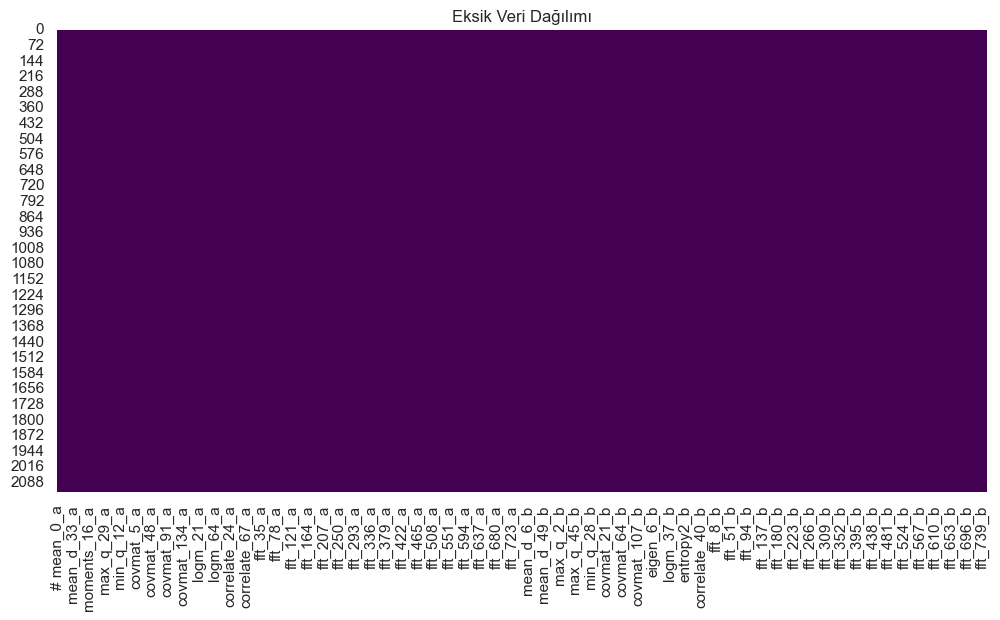

In [3]:
# Eksik Veri Analizi
print("=== EKSİK VERİ ANALİZİ ===")

# Her sütundaki eksik veri sayısını göster
print("\nEksik veri sayısı:")
print(df.isnull().sum())

# Her sütundaki eksik veri yüzdesini göster
print("\nEksik veri yüzdesi:")
print((df.isnull().sum() / len(df)) * 100)

# Eksik veri dağılımını görselleştir
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Eksik Veri Dağılımı')
plt.savefig('eksik_veri_analizi.png')
plt.show()

In [4]:
# Aykırı Değer Analizi için yardımcı fonksiyon
def detect_outliers(df, columns):
    """
    IQR yöntemi ile aykırı değerleri tespit etme
    """
    outlier_indices = []
    for col in columns:
        Q1 = df[col].quantile(0.25)  # 1. çeyrek
        Q3 = df[col].quantile(0.75)  # 3. çeyrek
        IQR = Q3 - Q1  # Çeyrekler arası aralık
        lower_bound = Q1 - 1.5 * IQR  # Alt sınır
        upper_bound = Q3 + 1.5 * IQR  # Üst sınır
        outlier_list_col = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_indices.extend(outlier_list_col)
    return list(set(outlier_indices))


=== AYKIRI DEĞER ANALİZİ ===

Toplam aykırı değer sayısı: 828
Veri setinin %38.84'sinde aykırı değer bulunmaktadır


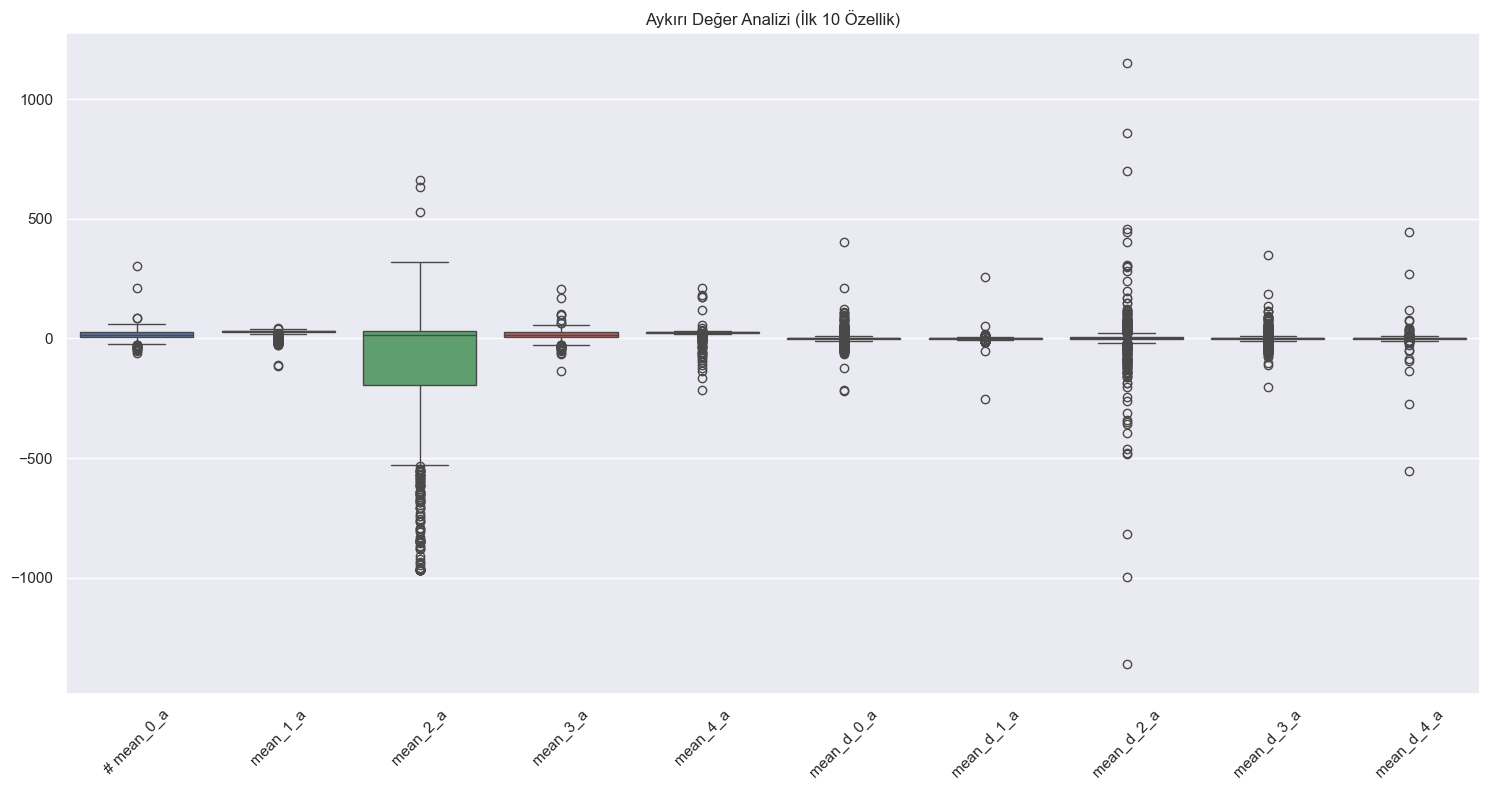

In [5]:
# Aykırı Değer Analizi Uygulaması
print("\n=== AYKIRI DEĞER ANALİZİ ===")

# İlk 10 özellik için aykırı değer analizi
columns_to_check = df.columns[:10]
outlier_indices = detect_outliers(df, columns_to_check)

# Aykırı değer istatistiklerini gösterme
print(f"\nToplam aykırı değer sayısı: {len(outlier_indices)}")
print(f"Veri setinin %{len(outlier_indices)/len(df)*100:.2f}'sinde aykırı değer bulunmaktadır")

# Aykırı değerleri görselleştir
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[columns_to_check])
plt.title('Aykırı Değer Analizi (İlk 10 Özellik)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('aykiri_deger_analizi.png')
plt.show()

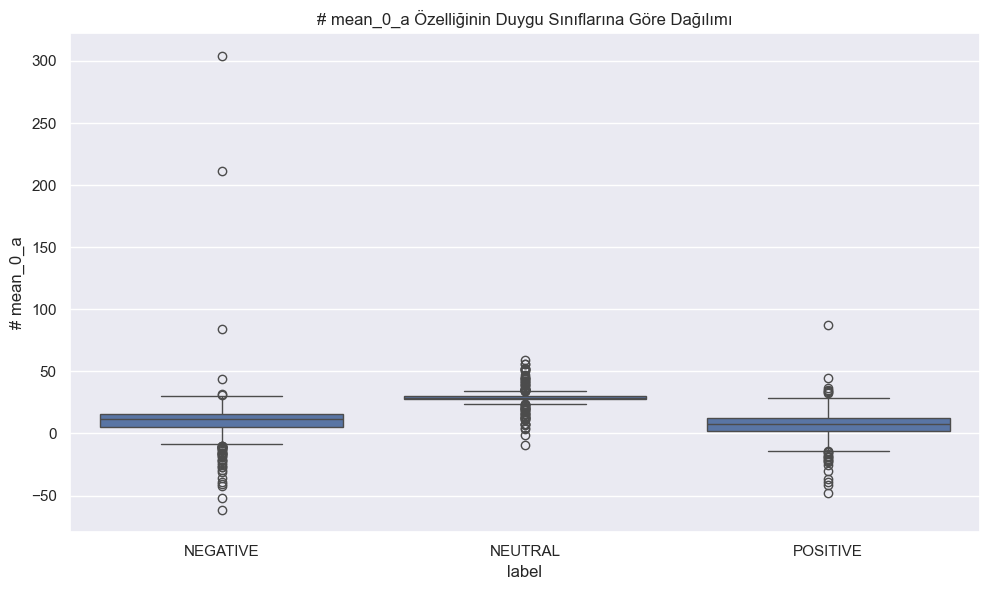

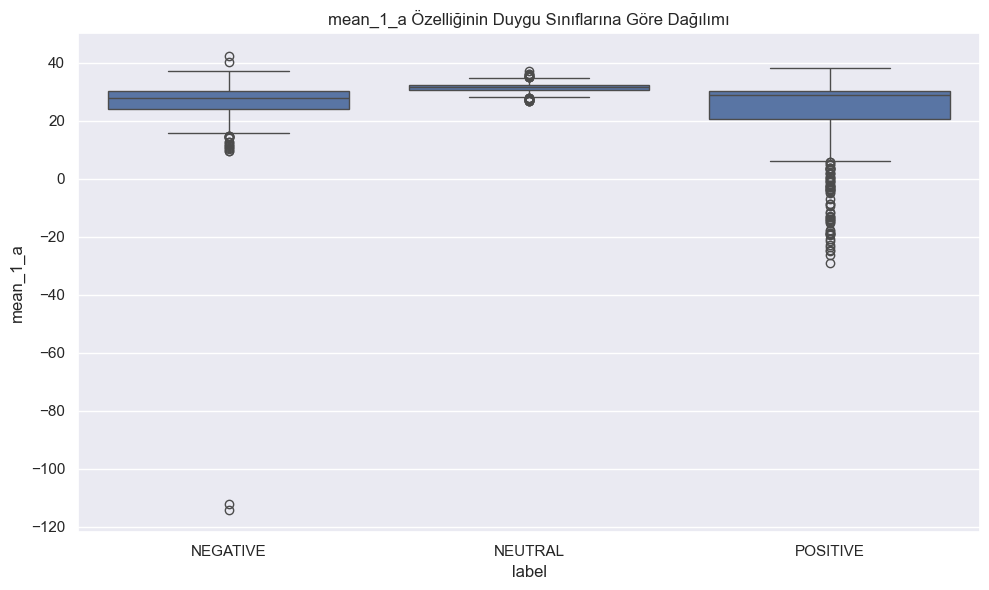

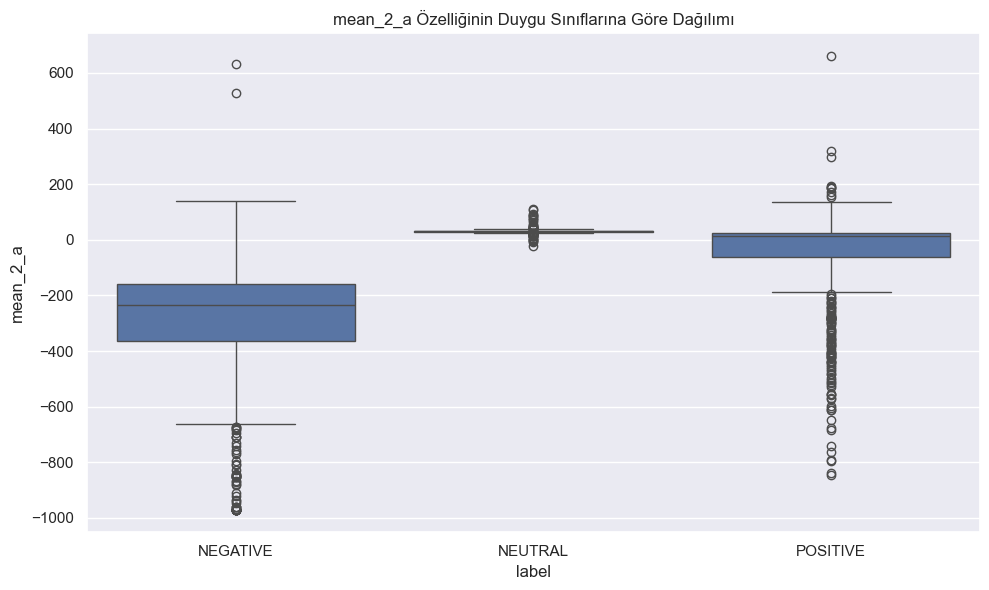

In [6]:
# Aykırı Değerlerin Duygu Sınıflarına Göre Dağılımı
# İlk 3 özellik için duygu sınıflarına göre aykırı değer analizi
for col in columns_to_check[:3]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='label', y=col, data=df)
    plt.title(f'{col} Özelliğinin Duygu Sınıflarına Göre Dağılımı')
    plt.tight_layout()
    plt.savefig(f'aykiri_deger_{col}.png')
    plt.show()


=== VERİ TEMİZLEME VE DÖNÜŞTÜRME ===


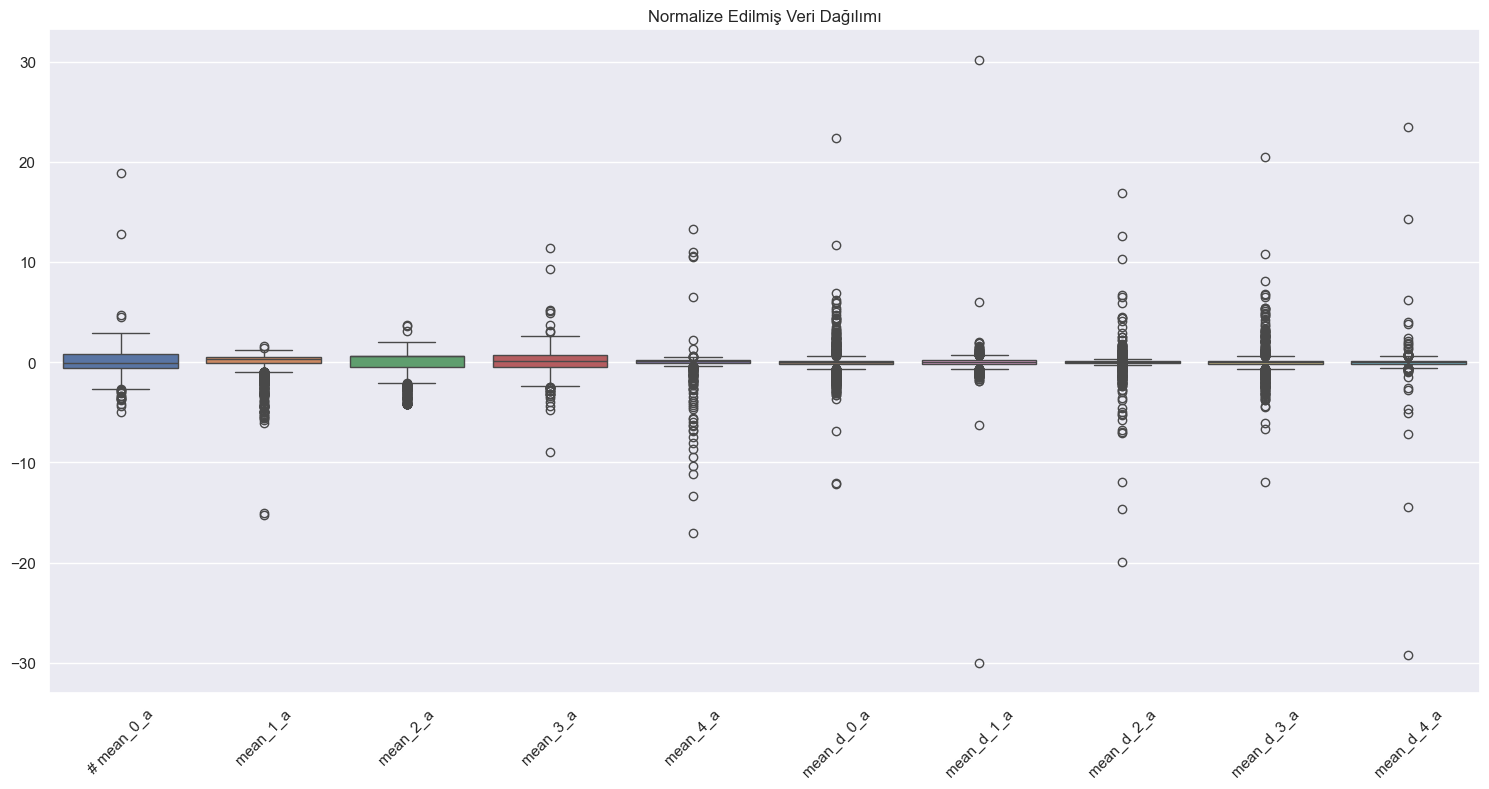

In [7]:
# Veri Temizleme ve Normalizasyon
print("\n=== VERİ TEMİZLEME VE DÖNÜŞTÜRME ===")

# Z-score normalizasyonu uygula
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df.drop('label', axis=1)), columns=df.drop('label', axis=1).columns)
df_normalized['label'] = df['label']

# Normalize edilmiş verinin dağılımını göster
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_normalized[columns_to_check])
plt.title('Normalize Edilmiş Veri Dağılımı')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('normalize_edilmis_veri.png')
plt.show()

In [8]:
# İstatistiksel Özet
print("\nNormalize edilmiş verinin istatistiksel özeti:")
print(df_normalized[columns_to_check].describe())


Normalize edilmiş verinin istatistiksel özeti:
         # mean_0_a      mean_1_a      mean_2_a      mean_3_a      mean_4_a  \
count  2.132000e+03  2.132000e+03  2.132000e+03  2.132000e+03  2.132000e+03   
mean   2.207948e-17  1.849677e-16  1.833014e-17  6.665504e-17  1.816350e-16   
std    1.000235e+00  1.000235e+00  1.000235e+00  1.000235e+00  1.000235e+00   
min   -5.009929e+00 -1.522325e+01 -4.194595e+00 -8.927059e+00 -1.700157e+01   
25%   -5.679860e-01 -1.012053e-01 -4.365377e-01 -5.185552e-01 -3.881011e-02   
50%   -7.570916e-02  3.225250e-01  5.815321e-01  1.063441e-01  7.399295e-02   
75%    8.142828e-01  4.736644e-01  6.525715e-01  7.642889e-01  1.867960e-01   
max    1.889552e+01  1.650393e+00  3.714297e+00  1.140403e+01  1.331425e+01   

         mean_d_0_a    mean_d_1_a    mean_d_2_a    mean_d_3_a    mean_d_4_a  
count  2.132000e+03  2.132000e+03  2.132000e+03  2.132000e+03  2.132000e+03  
mean  -1.166463e-17 -3.332752e-18 -2.707861e-18  6.665504e-18  4.999128e-18  
std   

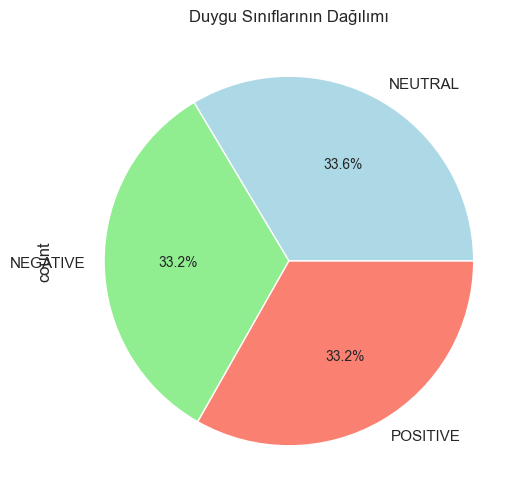

In [9]:
# Duygu sınıflarının pasta grafiği
plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', 
                               colors=['lightblue', 'lightgreen', 'salmon'])
plt.title('Duygu Sınıflarının Dağılımı')
# Görseli kaydet
plt.savefig('sekil1_duygu_dagilimi.png', dpi=300, bbox_inches='tight')
plt.show()

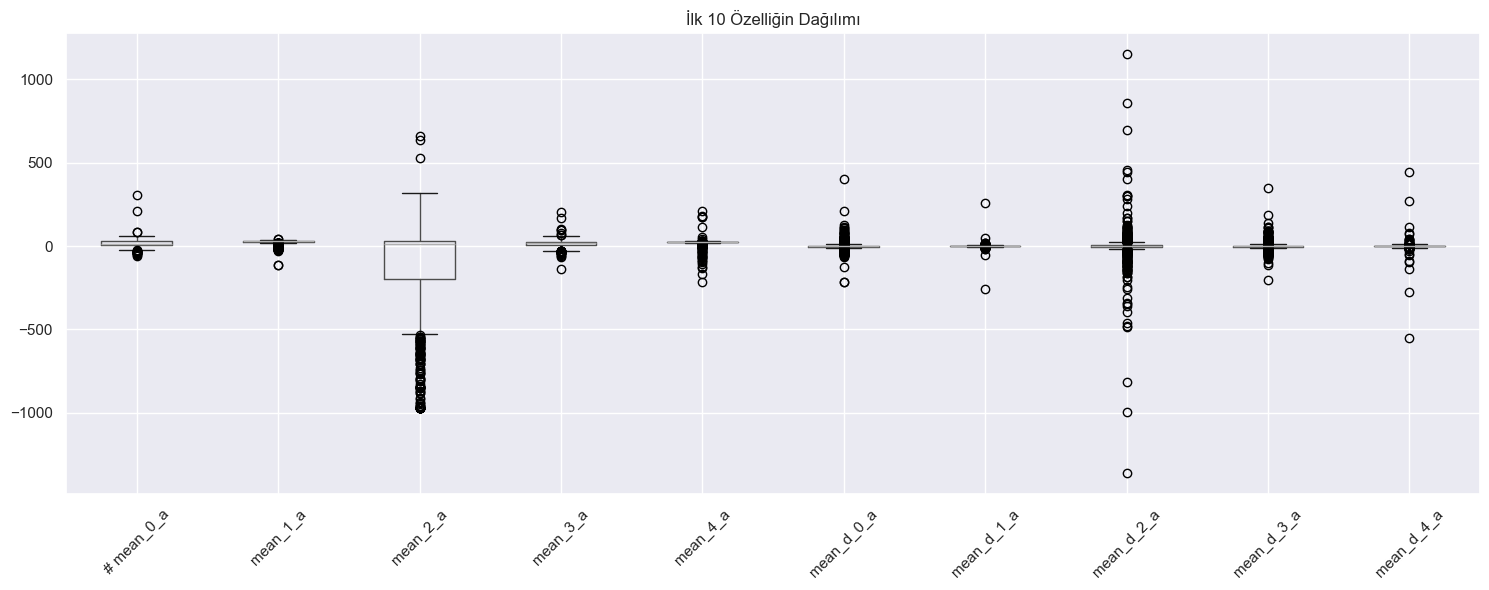

In [10]:
# İlk 10 özelliğin kutu grafikleri
plt.figure(figsize=(15, 6))
df.iloc[:, :10].boxplot()
plt.title('İlk 10 Özelliğin Dağılımı')
plt.xticks(rotation=45)
plt.tight_layout()
# Görseli kaydet
plt.savefig('sekil2_ozellik_dagilimi.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Veri ön işleme
# Etiket kodlaması
le = LabelEncoder()
y = le.fit_transform(df['label'])
X = df.drop('label', axis=1)

# Veri setini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Özellik ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Eğitim seti boyutu:", X_train_scaled.shape)
print("Test seti boyutu:", X_test_scaled.shape)

Eğitim seti boyutu: (1705, 2548)
Test seti boyutu: (427, 2548)


In [12]:
# Modellerin eğitilmesi
models = {
    'SVM': SVC(kernel='rbf', C=1.0, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Her modeli eğitmesi ve sonuçları saklama
results = {}
for name, model in models.items():
    print(f"\n{name} eğitiliyor...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        'predictions': y_pred,
        'accuracy': accuracy_score(y_test, y_pred)
    }
    print(f"{name} doğruluk: {results[name]['accuracy']:.4f}")


SVM eğitiliyor...
SVM doğruluk: 0.9578

Random Forest eğitiliyor...
Random Forest doğruluk: 0.9883

Decision Tree eğitiliyor...
Decision Tree doğruluk: 0.9438


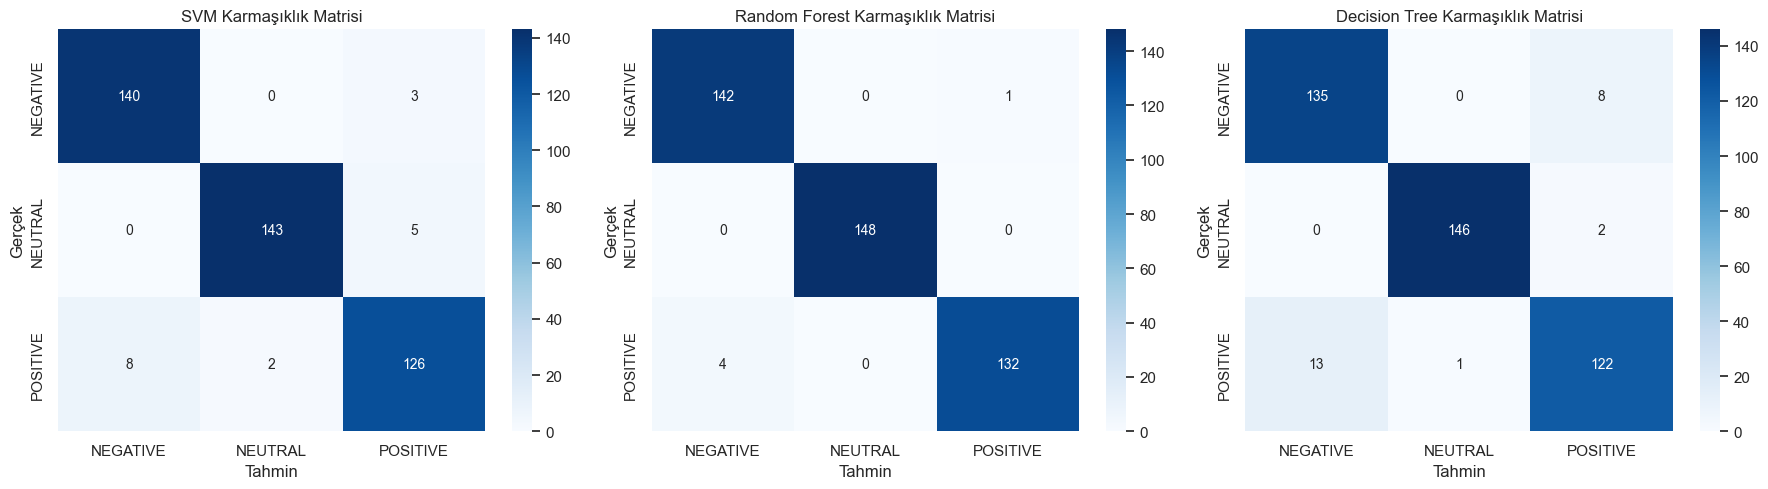

In [13]:
# Karmaşıklık matrislerinin görselleştirilmesi
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, result) in zip(axes, results.items()):
    cm = confusion_matrix(y_test, result['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    ax.set_title(f'{name} Karmaşıklık Matrisi')
    ax.set_xlabel('Tahmin')
    ax.set_ylabel('Gerçek')

plt.tight_layout()
# Görseli kaydet
plt.savefig('sekil3_karmasiklik_matrisleri.png', dpi=300, bbox_inches='tight')
plt.show()

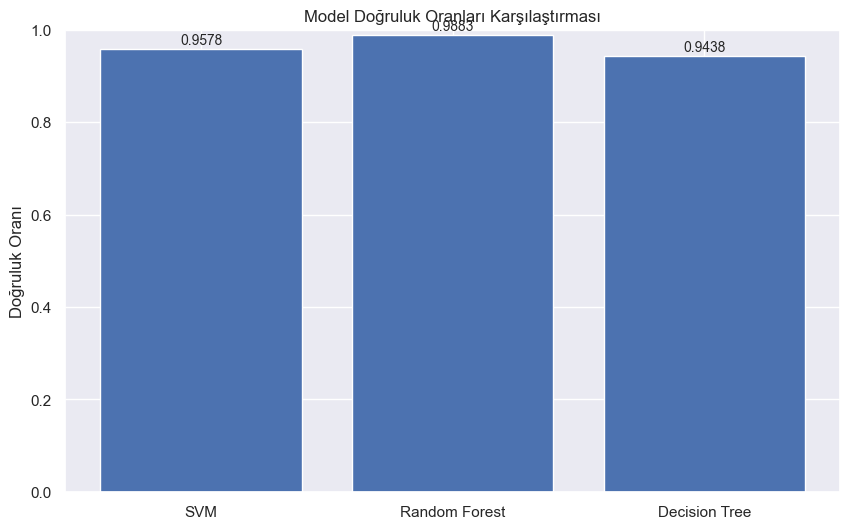

In [14]:
# Model karşılaştırma grafiği
plt.figure(figsize=(10, 6))
accuracies = {name: result['accuracy'] for name, result in results.items()}
plt.bar(accuracies.keys(), accuracies.values())
plt.title('Model Doğruluk Oranları Karşılaştırması')
plt.ylabel('Doğruluk Oranı')
plt.ylim(0, 1)
for i, v in enumerate(accuracies.values()):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
# Görseli kaydet
plt.savefig('sekil4_model_karsilastirma.png', dpi=300, bbox_inches='tight')
plt.show()

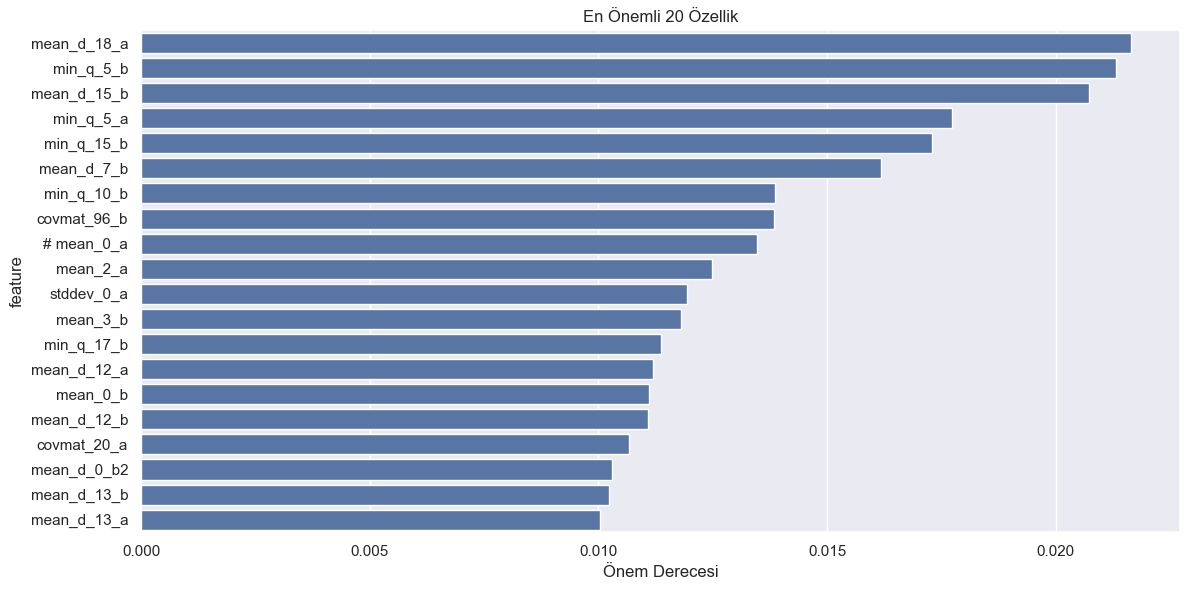

In [15]:
# Özellik önem analizi (Random Forest için)
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# En önemli 20 özelliğin görselleştirilmesi
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('En Önemli 20 Özellik')
plt.xlabel('Önem Derecesi')
plt.tight_layout()
# Görseli kaydet
plt.savefig('sekil5_ozellik_onem.png', dpi=300, bbox_inches='tight')
plt.show()